# EvoComp, lab 1
*Grigorev Mikhail J4233c*

Dependencies:

In [1]:
%pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.3 MB/s eta 0:00:00


Goal: to train an evolutionary algorithm to solve the classic optimization function. The function is **Rastrigin** function, but reversed and shifted.

> The maximum achieved value is 10, so the closer the end result to 10 - the better!



## Seminar Example

In [2]:
import math
from multiprocessing import Pool

import numpy as np
import numpy.random as rnd

import deap
from deap import tools, base, creator, algorithms

import matplotlib.pyplot as plt

In [3]:
noise = rnd.random(1000)

def rastrigin(individual):
    """Shifted Rastrigin function"""
    individual = individual + noise[0:len(individual)]
    n = len(individual)

    pi = math.pi
    dn = 1.0 / n
    a = 10.0
    b = 0.2
    c = 2 * pi
    s1 = 0.0
    s2 = 0.0
    for i in range(n):
        s1 += individual[i] * individual[i]
        s2 += np.cos(c*individual[i])
    s1 = -a * math.exp(-b*math.sqrt(dn*s1))
    s2 = -math.exp(dn*s2)
    result = s1+s2 + a + math.exp(1)
    result = -result
    result = result + a
    result = math.fabs(result)
    return result

In [4]:
noise.max()

0.999271948150876

In [5]:
solution = [0] * 20
rastrigin(solution)

7.205753233891501

In [7]:
creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

In [8]:
def mutation(individual):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.15:
            individual[i] += rnd.normal(0.0, 0.2)
            individual[i] = np.clip(individual[i], -5, 5)
    return individual,

In [14]:
class SimpleGAExperiment:
    def factory(self):
        """Returns random array in the half-open interval [-5, 5)"""
        return rnd.random(self.dimension) * 10 - 5

    def __init__(self, function, dimension, pop_size, iterations):
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = 0.6
        self.cross_prob = 0.3

        self.function = function
        self.dimension = dimension

        self.engine = base.Toolbox()
        self.engine.register("map", map)
        self.engine.register("individual", tools.initIterate,
                             creator.Individual, self.factory)
        self.engine.register("population", tools.initRepeat, list,
                             self.engine.individual, self.pop_size)

        self.engine.register("mate", tools.cxOnePoint)
        self.engine.register("mutate", tools.mutGaussian,
                             mu=0, sigma=0.5, indpb=0.2)
        self.engine.register("select", tools.selTournament, tournsize=4)
        self.engine.register("evaluate", self.function)


    def run(self):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, np.array_equal)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = algorithms.eaMuPlusLambda(pop, self.engine, mu=self.pop_size,
                                             lambda_=int(self.pop_size*0.8),
                                             cxpb=self.cross_prob,
                                             mutpb=self.mut_prob,
                                             ngen=self.iterations,
                                             stats=stats, halloffame=hof,
                                             verbose=False)
        print("Best = {}".format(hof[0]))
        print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log

In [15]:
def function(x):
    res = rastrigin(x)
    return res,

dimension = 100
pop_size = 100
iterations = 5000
scenario = SimpleGAExperiment(function, dimension, pop_size, iterations)

In [41]:
def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return (np.array(gen_list), np.array(avg_list),
            np.array(std_list), np.array(max_list), np.array(min_list))

def draw_log(log):
    c_u, c_r, c_b = "cornflowerblue", "indianred", "black"
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg", color=c_b, linewidth=1)
    plt.plot(gen_list, min_list, label="min", color=c_r, linewidth=1, alpha=0.3)
    plt.plot(gen_list, max_list, label="max", color=c_u, linewidth=1, alpha=0.3)
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.5)
    plt.legend()
    plt.show()

Best = [ 6.35279483e-01  7.05332552e-02  1.68974463e+00 -5.00566930e-01
 -1.38633891e+00  8.53210254e-01 -3.00149313e+00  2.67248104e+00
 -1.73689184e+00  9.88183610e-01  1.51739697e+00 -1.72329313e-01
  1.63106347e+00  1.36967301e+00  2.98720155e-01 -4.16977621e+00
  1.24528350e+00  7.02272615e-01 -1.59369290e+00 -1.03986666e-01
  6.27766209e-01  5.10432523e-01 -2.08338665e+00  6.96301235e-01
  1.55557149e+00 -1.25458288e+00 -3.55110793e+00  6.78449796e-01
 -2.49847961e+00 -1.67170582e+00  3.72224669e+00 -2.02494006e+00
 -2.19690884e+00 -1.06327371e-01 -4.10391339e+00  1.81039907e+00
  1.55474342e+00 -2.07874101e+00  6.11791655e-01 -3.36308910e+00
 -1.78155549e+00 -1.48376685e-01  6.24715792e-01 -1.92107025e+00
 -5.83361393e-01  7.78115300e-03  9.33607602e-01  7.71612018e-01
  3.25422508e+00 -4.83247764e+00  7.77698855e-01  2.54542238e+00
 -1.35142311e+00 -4.92540549e-01  1.47050709e+00 -1.38254483e+00
 -2.77074753e+00 -3.68862986e-01  8.77595037e-01 -3.10247170e+00
 -2.23402127e+00  

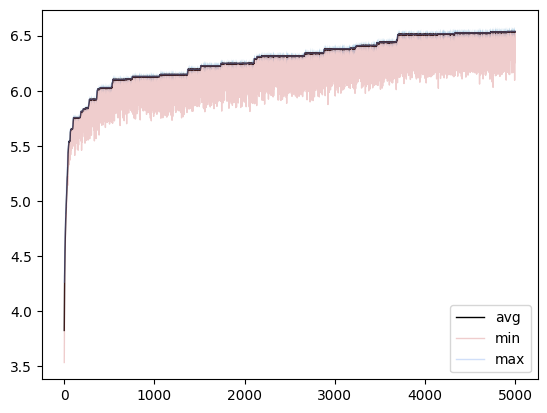

In [42]:
log = scenario.run()
draw_log(log)

## Modified version

In [43]:
class SimpleGAExperiment:
    def factory(self):
        """Returns random array in the half-open interval [-5, 5)"""
        return rnd.random(self.dimension) * 10 - 5

    def __init__(self, function, dimension, pop_size, iterations):
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = 0.9
        self.cross_prob = 0.1

        self.function = function
        self.dimension = dimension

        # concurrency
        self.pool = Pool(8)

        self.toolbox = base.Toolbox()
        self.toolbox.register("map", self.pool.map)
        self.toolbox.register("individual", tools.initIterate,
                              creator.Individual, self.factory)
        self.toolbox.register("population", tools.initRepeat, list,
                              self.toolbox.individual, self.pop_size)

        self.toolbox.register("mate", tools.cxOnePoint)
        self.toolbox.register("mutate", tools.mutGaussian,
                              mu=1, sigma=1.5, indpb=0.02)
        self.toolbox.register("select", tools.selTournament, tournsize=4)
        self.toolbox.register("evaluate", self.function)


    def run(self):
        pop = self.toolbox.population()
        hof = tools.HallOfFame(3, np.array_equal)

        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = algorithms.eaMuPlusLambda(
            pop,
            self.toolbox,
            mu=self.pop_size,
            lambda_=int(self.pop_size*0.8),
            cxpb=self.cross_prob,
            mutpb=self.mut_prob,
            ngen=self.iterations,
            stats=stats,
            halloffame=hof,
            verbose=False,
        )

        print("Best = {}".format(hof[0]))
        print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log

In [46]:
def function(x):
    res = rastrigin(x)
    return res,

dimension = 100
pop_size = 100
iterations = 5000
scenario = SimpleGAExperiment(function, dimension, pop_size, iterations)

Best = [-0.3788902  -0.88244407 -0.2849722  -0.4232657  -0.46186159 -0.15613612
  0.00318613 -0.42143888 -0.72240449 -0.94504182 -0.50363219 -0.20832895
 -0.3716518  -0.7758955  -0.64662602 -0.04311711 -0.7861948  -0.25077826
 -0.54075887 -0.14062293 -0.34091688 -0.52807021 -0.96177264 -0.41614323
 -0.54347658 -0.22844426 -0.51461657 -0.28054187 -0.89262622 -0.62518162
 -0.2774184  -0.01154425 -0.27755348 -0.14590964 -0.00983728 -0.37911792
 -0.40727948 -0.00425695 -0.33462889 -0.32121283 -0.69767327 -0.04570379
 -0.19131626 -0.87225198 -0.69923535 -0.97408819 -0.11893686 -0.198705
 -0.68925673 -0.99259574 -0.07182452 -0.32622137 -0.35156079 -0.74415758
 -0.39393186 -0.34992424 -0.72356762 -0.24890591 -0.06926949 -0.22984381
 -0.21978622 -0.52892824 -0.78041713 -0.66717986 -0.14041539 -0.34620019
 -0.01772395 -0.83168755 -0.5611972  -0.60174472 -0.15114727 -0.51187455
 -0.81708677 -0.68465028 -0.07121071 -0.72952233 -0.21137148 -0.62064436
 -0.94878019 -0.745951   -0.08520515 -0.021831

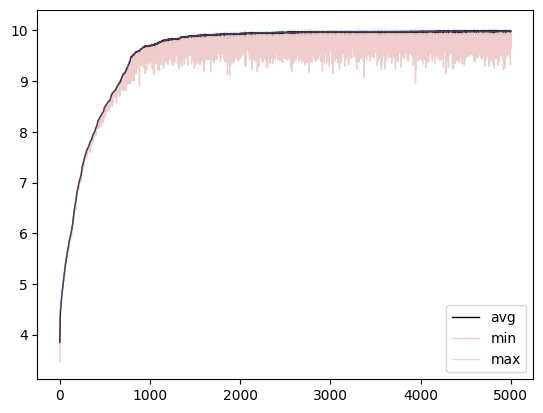

In [47]:
log = scenario.run()
draw_log(log)

> Acquired best fit: **9.988**